# Data Preparation - Campo Grande

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy import stats
import readHistData as hist

## 1. Load Observed Data from CSV

In [2]:
# Load the CSV data
df = pd.read_csv('../data/CampoGrande.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 26 rows of data


,ADT_Carlota,ADT_Guanandi,ADT_Planalto,OVT_Carlota,OVT_Guanandi,OVT_Planalto,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,8.396947,4.255319,10.729614,60.526316,35.593220,49.137931,2009_12,74.075,18.7850,22.264035,26.6675
1,4.950495,8.379888,6.808511,NaN,NaN,51.538462,2010_01,44.250,18.5450,21.515932,25.5750
2,2.857143,3.875969,7.627119,35.714286,41.025641,52.542373,2010_02,56.825,17.8075,21.617614,25.0350
3,2.690583,4.379562,4.602510,29.729730,23.333333,47.457627,2010_03,29.350,17.8225,21.994655,26.1450
4,1.282051,7.586207,3.361345,31.355932,31.578947,36.111111,2010_04,15.500,15.2700,20.112675,26.4125


In [3]:
# Convert months to days (month index * 30)
days = [i * 30 for i in range(len(df))]

# Extract OVT and ADT data for each neighborhood
# Handle missing values by forward filling then backward filling
CarlotaOVT = df['OVT_Carlota'].ffill().bfill().values
GuanandiOVT = df['OVT_Guanandi'].ffill().bfill().values
PlanaltoOVT = df['OVT_Planalto'].ffill().bfill().values

CarlotaADT = df['ADT_Carlota'].ffill().bfill().values
GuanandiADT = df['ADT_Guanandi'].ffill().bfill().values
PlanaltoADT = df['ADT_Planalto'].ffill().bfill().values

print(f"Days: {days[:5]}... to {days[-5:]}")
print(f"Number of time points: {len(days)}")

Days: [0, 30, 60, 90, 120]... to [630, 660, 690, 720, 750]
Number of time points: 26


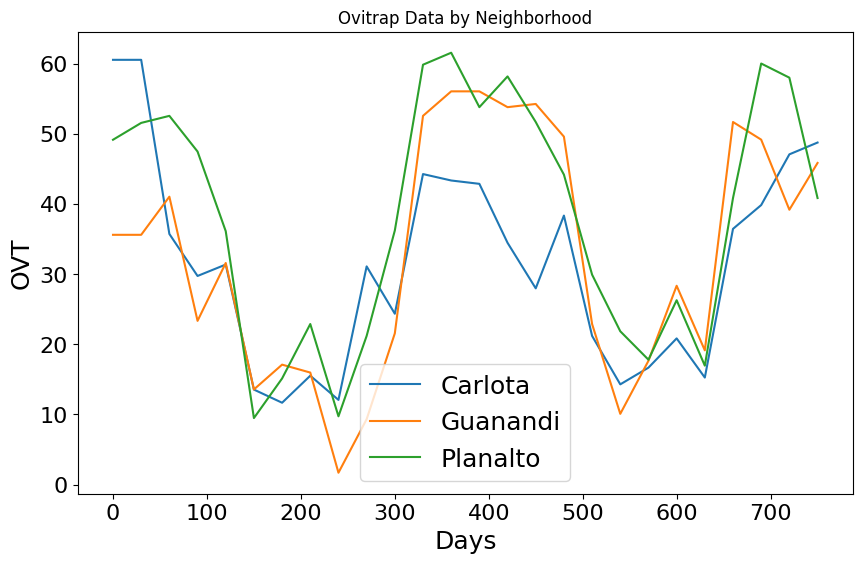

In [4]:
# Plot OVT data
plt.figure(figsize=(10, 6))
plt.plot(days, CarlotaOVT, label='Carlota')
plt.plot(days, GuanandiOVT, label='Guanandi')
plt.plot(days, PlanaltoOVT, label='Planalto')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Ovitrap Data by Neighborhood")
plt.show()

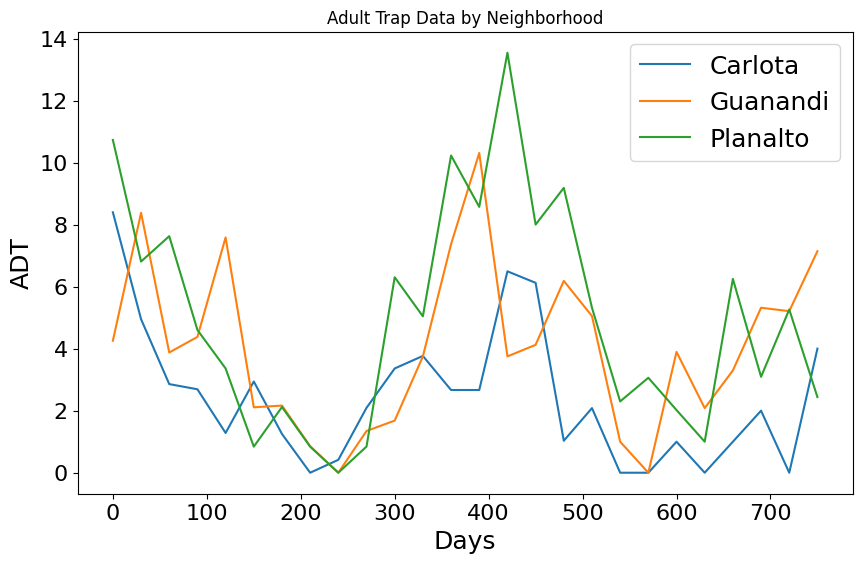

In [5]:
# Plot ADT data
plt.figure(figsize=(10, 6))
plt.plot(days, CarlotaADT, label='Carlota')
plt.plot(days, GuanandiADT, label='Guanandi')
plt.plot(days, PlanaltoADT, label='Planalto')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("ADT", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Adult Trap Data by Neighborhood")
plt.show()

## 2. Extract Terrain Proportions from Maps

Each neighborhood has its own satellite and roadmap images already separated.

In [6]:
import math as m

def isGreen(rgb):
    """Check if pixel is green (vegetation) in satellite image"""
    r, g, b = rgb
    # Green pixels have higher green channel relative to red and blue
    # Detect various shades of green in vegetation
    if g > r and g > b and g > 50:
        return True
    # Detect darker greens (trees)
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    """Check if pixel is a street in roadmap"""
    r, g, b = rgb_map
    # Streets in Campo Grande maps are light blue-gray (around 215, 223, 230)
    # They have higher blue component than red
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:  # relatively balanced R and G
            return True
    return False

def isWater(rgb_map):
    """Check if pixel is water in roadmap"""
    r, g, b = rgb_map
    # Water is typically more saturated blue
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    """
    Count terrain types from roadmap and satellite images.
    Returns counts: [water, parks, streets, houses]
    """
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    
    # Ensure same dimensions
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    
    water = 0
    parks = 0
    streets = 0
    houses = 0
    
    # Sample pixels (every nth pixel for performance)
    step = 3  # sample every 3rd pixel
    
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            
            # Check water first (from roadmap)
            if isWater(pixel_map):
                water += 1
            # Check streets (from roadmap)
            elif isStreet(pixel_map):
                streets += 1
            # Check parks/vegetation (from satellite)
            elif isGreen(pixel_sat):
                parks += 1
            # Everything else is houses
            else:
                houses += 1
    
    return [water, parks, streets, houses]

In [7]:
# Define paths to neighborhood maps
neighborhoods = ['Carlota', 'Guanandi', 'Planalto']
map_base_path = '../maps/CampoGrande_MS'

# Count terrain for each neighborhood
proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

print("\nRaw counts:")
for name, counts in zip(neighborhoods, proportions_raw):
    print(f"  {name}: water={counts[0]}, parks={counts[1]}, streets={counts[2]}, houses={counts[3]}")

Processing Carlota...
  Raw counts [water, parks, streets, houses]: [0, 8235, 27088, 147006]
Processing Guanandi...
  Raw counts [water, parks, streets, houses]: [0, 2686, 28827, 150816]
Processing Planalto...
  Raw counts [water, parks, streets, houses]: [0, 12800, 28385, 141144]

Raw counts:
  Carlota: water=0, parks=8235, streets=27088, houses=147006
  Guanandi: water=0, parks=2686, streets=28827, houses=150816
  Planalto: water=0, parks=12800, streets=28385, houses=141144


In [8]:
# Normalize to proportions
proportions = []
for counts in proportions_raw:
    total = sum(counts)
    props = np.array(counts) / total
    proportions.append(props)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")

Proportions [water, parks, streets, houses]:
  Carlota: water=0.0000, parks=0.0452, streets=0.1486, houses=0.8063
  Guanandi: water=0.0000, parks=0.0147, streets=0.1581, houses=0.8272
  Planalto: water=0.0000, parks=0.0702, streets=0.1557, houses=0.7741


In [9]:
# Build proportions matrix (neighborhoods x terrain types)
# Columns: water, parks, streets, houses
carlota = proportions[0]
guanandi = proportions[1]
planalto = proportions[2]

matProporcoes = np.matrix([carlota, guanandi, planalto])
print("Proportions Matrix (rows=neighborhoods, cols=[water, parks, streets, houses]):")
print(matProporcoes)

Proportions Matrix (rows=neighborhoods, cols=[water, parks, streets, houses]):
[[0.         0.04516561 0.1485666  0.80626779]
 [0.         0.01473161 0.15810431 0.82716408]
 [0.         0.07020277 0.15568012 0.77411712]]


## 3. Decompose OVT Data into Terrain Types

In [10]:
# Decompose OVT into terrain-specific values
O_agua, O_parque, O_rua, O_casa = [], [], [], []

for t in range(len(CarlotaOVT)):
    vetOvo = [CarlotaOVT[t], GuanandiOVT[t], PlanaltoOVT[t]]
    
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    
    result = optimize.minimize(f, [0, 0, 0, 0], 
                              bounds=[(0, None), (0, None), (0, None), (0, None)])
    
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua = np.array(O_agua)
O_parque = np.array(O_parque)
O_rua = np.array(O_rua)
O_casa = np.array(O_casa)

print("OVT decomposition complete.")

OVT decomposition complete.


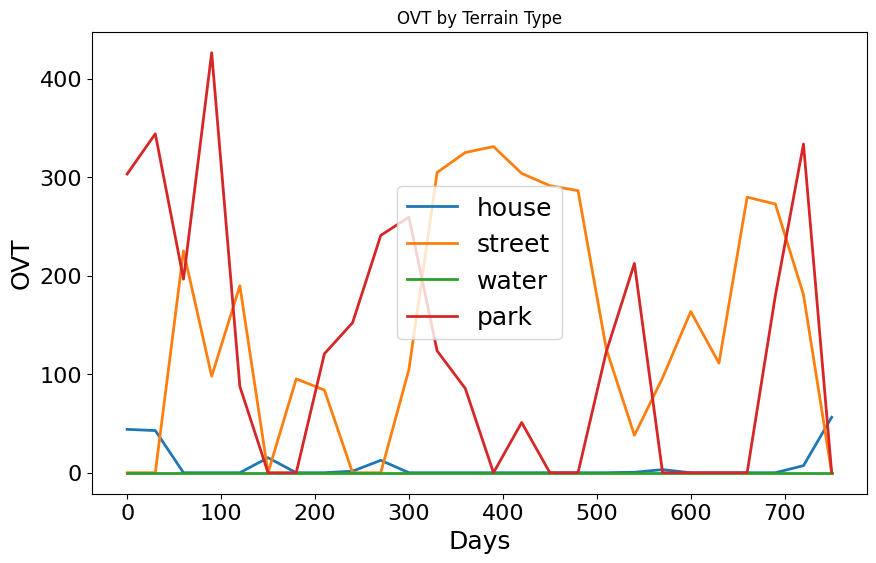

In [11]:
# Plot OVT by terrain type
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_agua, label="water", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data into Terrain Types

In [12]:
# Decompose ADT into terrain-specific values
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []

for t in range(len(CarlotaADT)):
    vetAdt = [CarlotaADT[t], GuanandiADT[t], PlanaltoADT[t]]
    
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    
    result = optimize.minimize(f, [0, 0, 0, 0], 
                              bounds=[(0, None), (0, None), (0, None), (0, None)])
    
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua = np.array(ADT_agua)
ADT_parque = np.array(ADT_parque)
ADT_rua = np.array(ADT_rua)
ADT_casa = np.array(ADT_casa)

print("ADT decomposition complete.")

ADT decomposition complete.


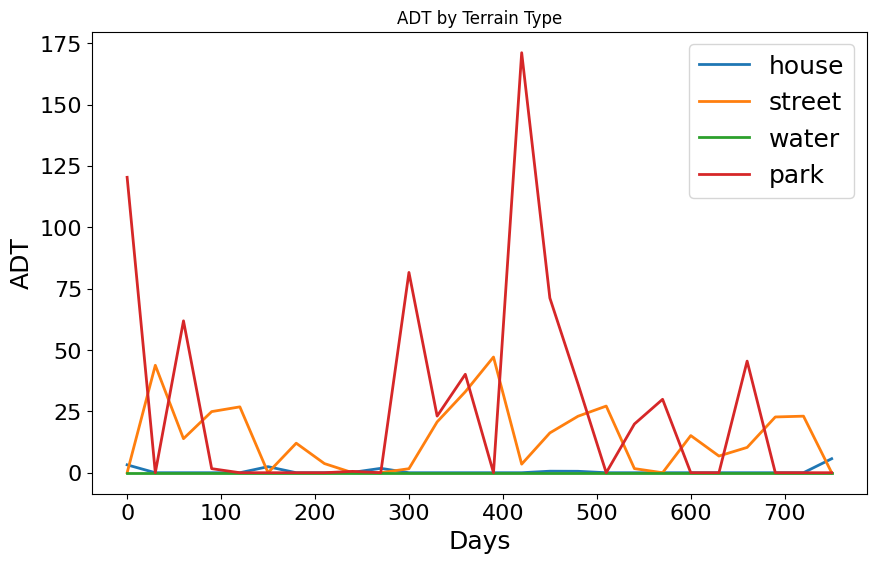

In [13]:
# Plot ADT by terrain type
plt.figure(figsize=(10, 6))
plt.plot(days, ADT_casa, label="house", linewidth=2)
plt.plot(days, ADT_rua, label="street", linewidth=2)
plt.plot(days, ADT_agua, label="water", linewidth=2)
plt.plot(days, ADT_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("ADT", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADT by Terrain Type")
plt.show()

## 5. Validate Reconstruction

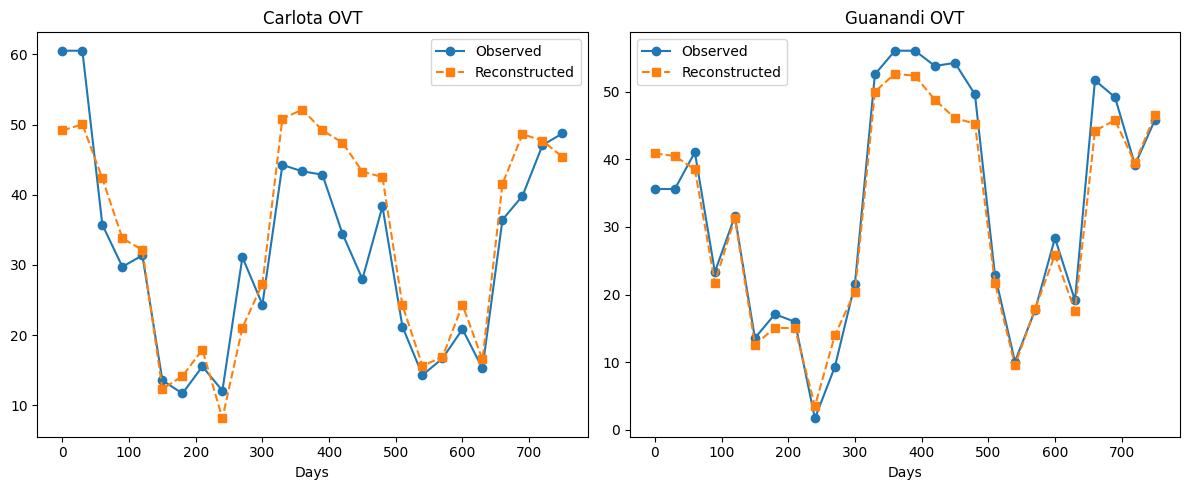

In [14]:
# Reconstruct neighborhood OVT from terrain values
CarlotaOVTR = np.zeros(len(CarlotaOVT))
GuanandiOVTR = np.zeros(len(CarlotaOVT))
PlanaltoOVTR = np.zeros(len(CarlotaOVT))

for t in range(len(CarlotaOVT)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    CarlotaOVTR[t], GuanandiOVTR[t], PlanaltoOVTR[t] = R[0,0], R[0,1], R[0,2]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(days, CarlotaOVT, 'o-', label='Observed')
plt.plot(days, CarlotaOVTR, 's--', label='Reconstructed')
plt.legend()
plt.title('Carlota OVT')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
plt.plot(days, GuanandiOVT, 'o-', label='Observed')
plt.plot(days, GuanandiOVTR, 's--', label='Reconstructed')
plt.legend()
plt.title('Guanandi OVT')
plt.xlabel('Days')
plt.tight_layout()
plt.show()

In [15]:
# Calculate correlations
from scipy.stats import pearsonr

print("Reconstruction Correlations:")
print("\nOVT:")
print(f"  Carlota: {pearsonr(CarlotaOVTR, CarlotaOVT)[0]:.4f}")
print(f"  Guanandi: {pearsonr(GuanandiOVTR, GuanandiOVT)[0]:.4f}")
print(f"  Planalto: {pearsonr(PlanaltoOVTR, PlanaltoOVT)[0]:.4f}")

# Reconstruct ADT
CarlotaADTR = np.zeros(len(CarlotaADT))
GuanandiADTR = np.zeros(len(CarlotaADT))
PlanaltoADTR = np.zeros(len(CarlotaADT))

for t in range(len(CarlotaADT)):
    R = matProporcoes @ [ADT_agua[t], ADT_parque[t], ADT_rua[t], ADT_casa[t]]
    CarlotaADTR[t], GuanandiADTR[t], PlanaltoADTR[t] = R[0,0], R[0,1], R[0,2]

print("\nADT:")
print(f"  Carlota: {pearsonr(CarlotaADTR, CarlotaADT)[0]:.4f}")
print(f"  Guanandi: {pearsonr(GuanandiADTR, GuanandiADT)[0]:.4f}")
print(f"  Planalto: {pearsonr(PlanaltoADTR, PlanaltoADT)[0]:.4f}")

Reconstruction Correlations:

OVT:
  Carlota: 0.9034
  Guanandi: 0.9845
  Planalto: 0.9803

ADT:
  Carlota: 0.7852
  Guanandi: 0.9575
  Planalto: 0.9621


## 6. Plot Climate Data

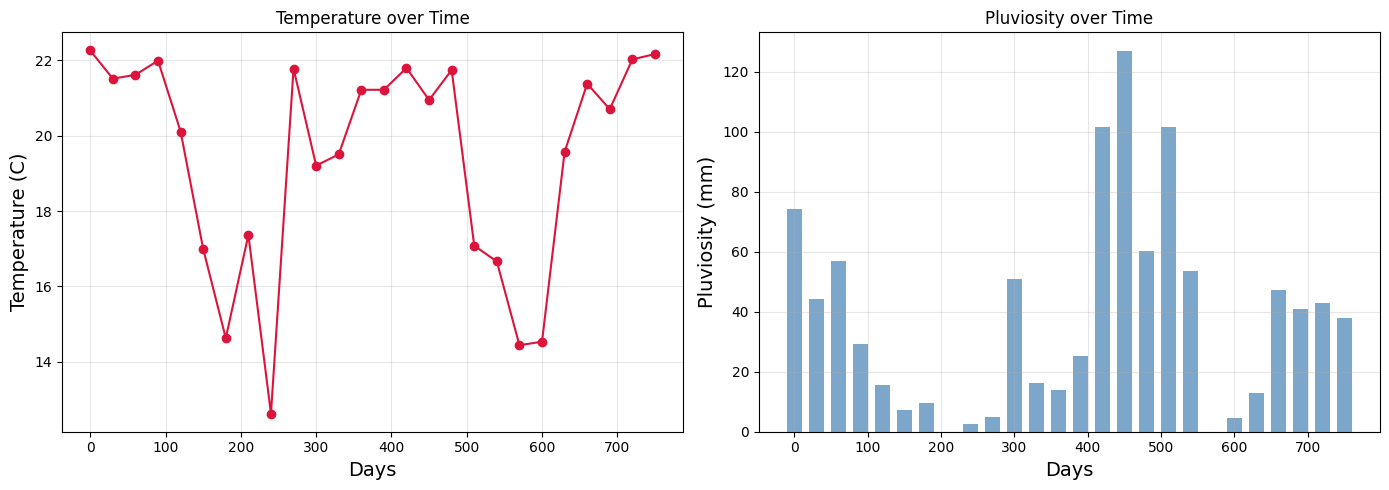

In [16]:
# Get temperature and pluviosity from readHistData
temperatures = [hist.temperature(t) for t in days]
pluviosities = [hist.pluviosity(t) for t in days]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(days, temperatures, 'o-', color='crimson')
axes[0].set_xlabel('Days', fontsize=14)
axes[0].set_ylabel('Temperature (C)', fontsize=14)
axes[0].set_title('Temperature over Time')
axes[0].grid(True, alpha=0.3)

axes[1].bar(days, pluviosities, width=20, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Days', fontsize=14)
axes[1].set_ylabel('Pluviosity (mm)', fontsize=14)
axes[1].set_title('Pluviosity over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Results to CSV

In [17]:
# Save decomposed data to dataNew.csv
data_new = {
    "Day": days,
    "OVT_house": O_casa,
    "OVT_park": O_parque,
    "OVT_street": O_rua,
    "ADT_house": ADT_casa,
    "ADT_park": ADT_parque,
    "ADT_street": ADT_rua,
    "Temperature": [hist.temperature(t) for t in days],
    "Pluviosity": [hist.pluviosity(t) for t in days]
}

df_new = pd.DataFrame(data_new)
df_new.to_csv("dataNew.csv", index=False)
print("Saved dataNew.csv")
df_new.head(10)

Saved dataNew.csv


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,44.000305,303.115848,0.000000,3.210498,120.338918,0.000000,22.264034722225,74.07499999999999
1,30,42.787514,343.946257,0.000000,0.000000,0.000000,43.760058,21.515932291650003,44.25
2,60,0.000000,196.465911,225.074052,0.000000,61.872981,13.872339,21.61761356705,56.825
3,90,0.000000,426.223380,97.933288,0.000000,1.659922,24.900416,21.9946545139,29.35
4,120,0.000000,87.520699,189.682171,0.000000,0.000000,26.830769,20.112675347225,15.5
5,150,15.244050,0.000000,0.000000,2.465426,0.000000,0.000000,16.99557291665,7.4
6,180,0.000000,0.000000,95.234710,0.000000,0.000000,12.029353,14.6279704861,9.5
7,210,0.000000,120.695241,83.889636,0.000000,0.000000,3.729814,17.369467361125,0.0
8,240,1.547962,152.268170,0.000000,0.144619,0.547091,0.000000,12.62690399305,2.425
9,270,12.611726,240.857569,0.000000,1.785750,0.000000,0.000000,21.784699652775,5.025


In [18]:
# Also save the proportions matrix for reference
props_df = pd.DataFrame(
    matProporcoes,
    index=neighborhoods,
    columns=['water', 'parks', 'streets', 'houses']
)
print("\nProportions Matrix:")
print(props_df)


Proportions Matrix:
          water     parks   streets    houses
Carlota     0.0  0.045166  0.148567  0.806268
Guanandi    0.0  0.014732  0.158104  0.827164
Planalto    0.0  0.070203  0.155680  0.774117
